In [ ]:
# Conectar google colab con google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
import cv2
from tensorflow.keras import layers, Sequential, datasets, Model
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install tensorflow-addons
!pip install dalle-pytorch
!pip install torch torchvision
!pip install pytorch-lightning==1.4.1
!pip install torchmetrics==0.5.1
!pip install torchtext==0.10.0.

ERROR: Could not find a version that satisfies the requirement torchtext==0.10.0. (from versions: 0.1.1, 0.2.0, 0.2.1, 0.2.3, 0.3.1, 0.4.0, 0.5.0, 0.6.0, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0)
ERROR: No matching distribution found for torchtext==0.10.0.


In [ ]:
from os import listdir
import numpy as np
from numpy import savez_compressed
import os
from os import listdir
import cv2
from numpy import asarray, vstack, savez_compressed
from numpy.random import randint
from glob import glob
from random import random
from tqdm import tqdm
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from keras.layers import ReLU, Input,Conv2D,Dropout,LeakyReLU, Activation, Concatenate, Conv2DTranspose
from keras.models import load_model,Model ,Sequential
from tensorflow_addons.layers import InstanceNormalization
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

Load image

In [ ]:
def load_images(folder_path, img_size=(128, 128)):
    X = []
    limit = 4000
    for img_name in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img_array = cv2.imread(img_path)
        img_array = cv2.resize(img_array, img_size)
        img_array = img_array[:, :, ::-1]
        X.append(img_array / 255.0)
        if len(X) >= limit:
            break
    return np.array(X)


In [ ]:
celeb_path = r"/content/drive/MyDrive/MADRID/APPR/fakeface/img_align_celeba/img_align_celeba/img_align_celeba/"
cartoon_path = r"/content/drive/MyDrive/MADRID/APPR/fakeface/simpson/cropped/"

dataA = load_images(celeb_path)
print('Loaded dataA:', dataA.shape)

dataB = load_images(cartoon_path)
print('Loaded dataB:', dataB.shape)


100%|██████████| 944/944 [00:16<00:00, 58.77it/s]


Loaded dataA: (944, 128, 128, 3)


100%|██████████| 1077/1077 [00:20<00:00, 51.61it/s] 


Loaded dataB: (1077, 128, 128, 3)


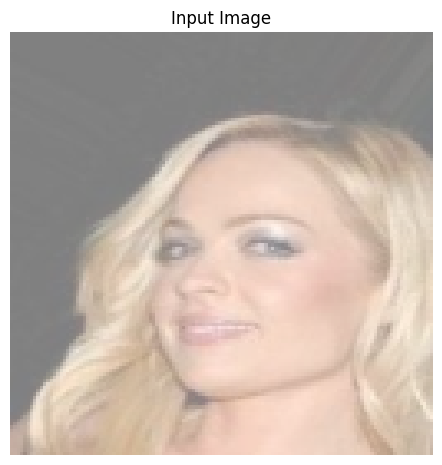

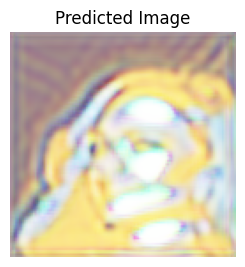

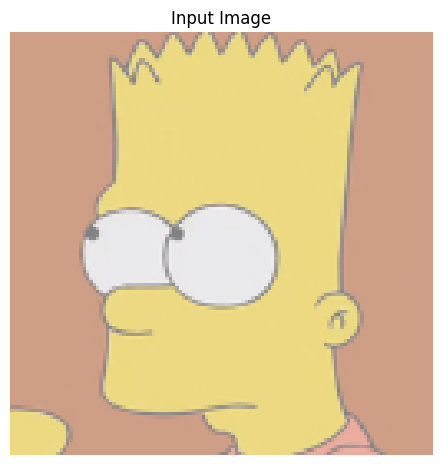

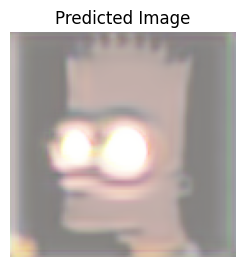

In [ ]:


# Définir la fonction du bloc ResNet
def resnet_block(n_filters, input_layer):
    init = RandomNormal(stddev=0.02)
    copy_input = input_layer
    x = layers.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer=init)(input_layer)
    x = InstanceNormalization(axis=-1)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = layers.Add()([x, copy_input])
    return x

# Définir le générateur
def define_generator(image_shape, n_resnet=9):
    init = RandomNormal(stddev=0.02)
    input_image = tf.keras.Input(shape=image_shape)
    x = layers.Conv2D(64, (7, 7), padding='same', kernel_initializer=init)(input_image)
    x = InstanceNormalization(axis=-1)(x)
    x = layers.Activation('relu')(x)

    c1 = layers.Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=init)(x)
    c1 = InstanceNormalization(axis=-1)(c1)
    c1 = layers.Activation('relu')(c1)

    c2 = layers.Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=init)(c1)
    c2 = InstanceNormalization(axis=-1)(c2)
    c2 = layers.Activation('relu')(c2)

    for _ in range(n_resnet):
        x = resnet_block(256, c2)

    u1 = layers.UpSampling2D((2, 2))(x)
    u1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=init)(u1)
    u1 = InstanceNormalization(axis=-1)(u1)
    u1 = layers.Activation('relu')(u1)

    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=init)(u2)
    u2 = InstanceNormalization(axis=-1)(u2)
    u2 = layers.Activation('relu')(u2)

    output_image = layers.Conv2D(3, (7, 7), activation='tanh', padding='same', kernel_initializer=init)(u2)

    model = tf.keras.Model(input_image, output_image)
    return model

# Définir le discriminateur
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    input_image = tf.keras.Input(shape=image_shape)
    x = layers.Conv2D(64, (4, 4), strides=2, padding='same', kernel_initializer=init)(input_image)
    x = layers.LeakyReLU(alpha=0.2)(x)

    d1 = layers.Conv2D(128, (4, 4), strides=2, padding='same', kernel_initializer=init)(x)
    d1 = layers.LeakyReLU(alpha=0.2)(d1)

    d2 = layers.Conv2D(256, (4, 4), strides=2, padding='same', kernel_initializer=init)(d1)
    d2 = InstanceNormalization(axis=-1)(d2)
    d2 = layers.LeakyReLU(alpha=0.2)(d2)

    d3 = layers.Conv2D(512, (4, 4), strides=2, padding='same', kernel_initializer=init)(d2)
    d3 = InstanceNormalization(axis=-1)(d3)
    d3 = layers.LeakyReLU(alpha=0.2)(d3)

    output = layers.Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d3)

    model = tf.keras.Model(input_image, output)
    return model

# Définir les modèles générateurs et discriminateurs
image_shape = dataA.shape[1:]
generator_AtoB = define_generator(image_shape)
generator_BtoA = define_generator(image_shape)
discriminator_A = define_discriminator(image_shape)
discriminator_B = define_discriminator(image_shape)

# Définir les fonctions de perte et les optimiseurs
lambda_cycle = 10.0
lambda_id = 0.5 * lambda_cycle
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_object(tf.ones_like(real), real)
    generated_loss = loss_object(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def calc_cycle_loss(real_image, cycled_image):
    real_image = tf.cast(real_image, tf.float32)
    cycled_image = tf.cast(cycled_image, tf.float32)
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss1

def identity_loss(real_image, same_image):
    real_image = tf.cast(real_image, tf.float32)
    same_image = tf.cast(same_image, tf.float32)
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_id * 0.5 * loss

# Initialise les optimizers pour tous les modèles
generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

# Applique les optimizers à toutes les variables des modèles
generator_optimizer.build(generator_AtoB.trainable_variables + generator_BtoA.trainable_variables)
discriminator_optimizer.build(discriminator_A.trainable_variables + discriminator_B.trainable_variables)

# Fonction pour entraîner le CycleGAN
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_AtoB(real_x, training=True)
        cycled_x = generator_BtoA(fake_y, training=True)
        fake_x = generator_BtoA(real_y, training=True)
        cycled_y = generator_AtoB(fake_x, training=True)

        same_x = generator_BtoA(real_x, training=True)
        same_y = generator_AtoB(real_y, training=True)

        disc_real_x = discriminator_A(real_x, training=True)
        disc_real_y = discriminator_B(real_y, training=True)
        disc_fake_x = discriminator_A(fake_x, training=True)
        disc_fake_y = discriminator_B(fake_y, training=True)

        gen_g_loss = loss_object(tf.ones_like(disc_fake_y), disc_fake_y)
        gen_f_loss = loss_object(tf.ones_like(disc_fake_x), disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_AtoB_gradients = tape.gradient(total_gen_g_loss, generator_AtoB.trainable_variables)
    generator_BtoA_gradients = tape.gradient(total_gen_f_loss, generator_BtoA.trainable_variables)

    discriminator_A_gradients = tape.gradient(disc_x_loss, discriminator_A.trainable_variables)
    discriminator_B_gradients = tape.gradient(disc_y_loss, discriminator_B.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_AtoB_gradients, generator_AtoB.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_BtoA_gradients, generator_BtoA.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_A_gradients, discriminator_A.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_B_gradients, discriminator_B.trainable_variables))

# Entraînement du CycleGAN
epochs = 1
for epoch in range(epochs):
    for i in range(len(dataA)):
        real_x = np.expand_dims(dataA[i], axis=0)
        real_y = np.expand_dims(dataB[i], axis=0)
        train_step(real_x, real_y)

# Transformation des visages humains en visages Simpson et vice versa
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

sample_human = dataA[0]
sample_simpson = dataB[0]

generate_images(generator_AtoB, np.expand_dims(sample_human, axis=0))
generate_images(generator_BtoA, np.expand_dims(sample_simpson, axis=0))

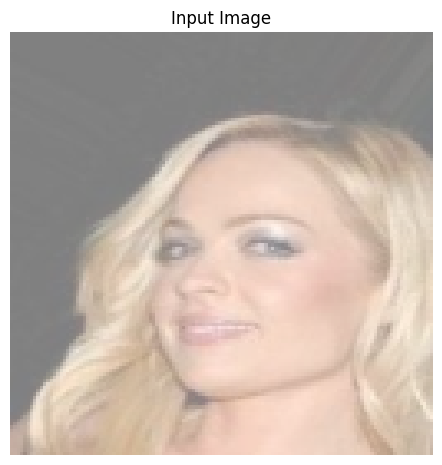

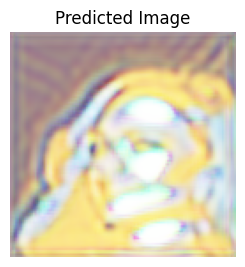

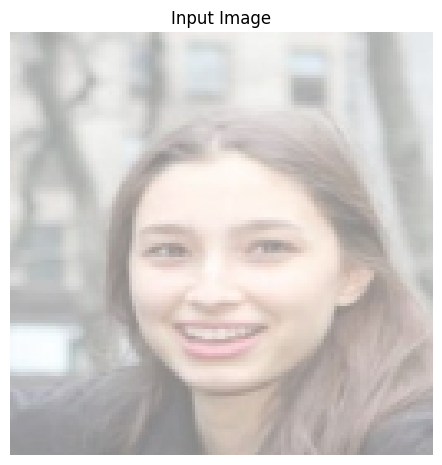

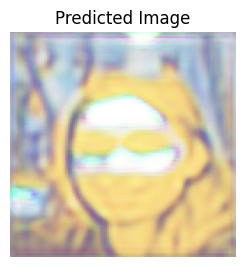

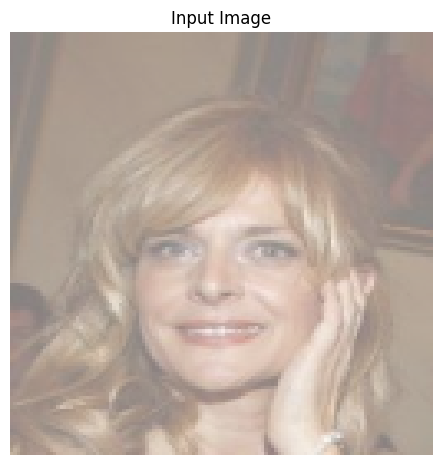

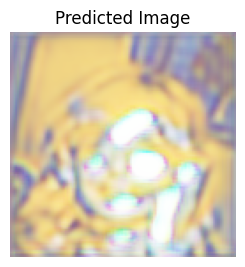

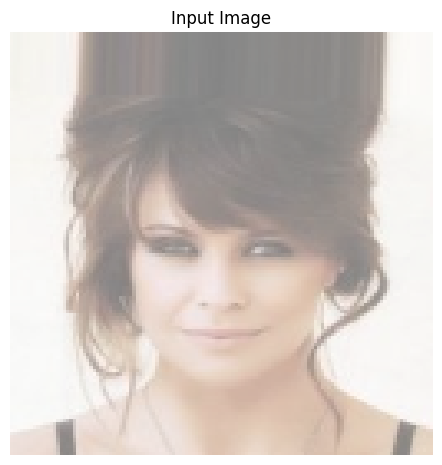

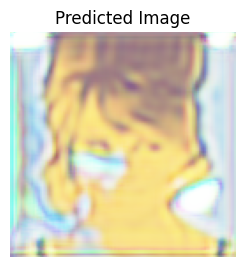

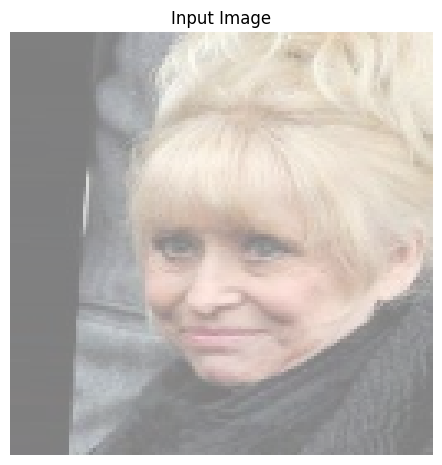

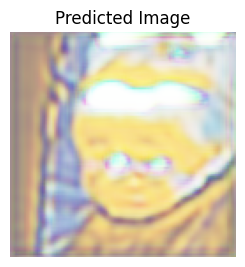

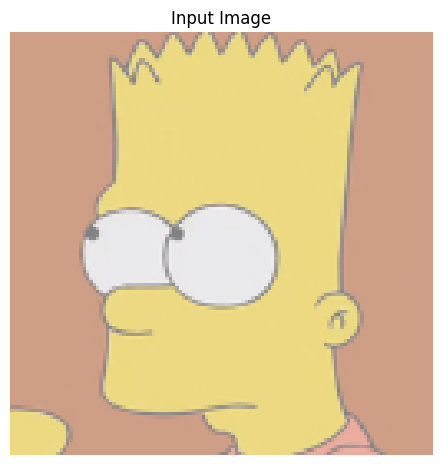

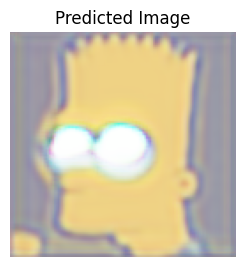

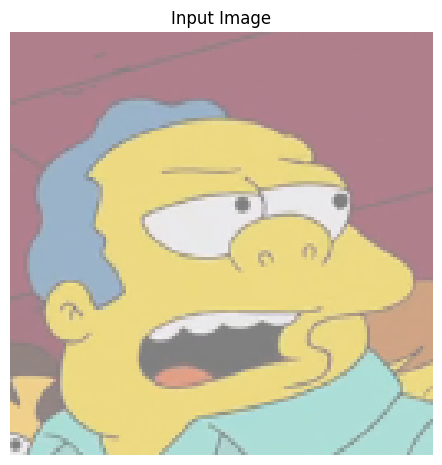

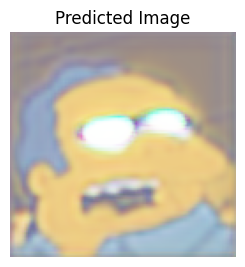

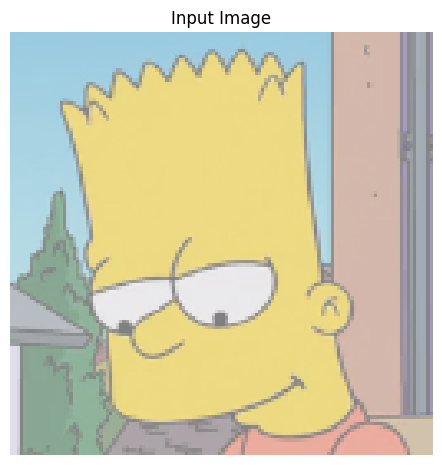

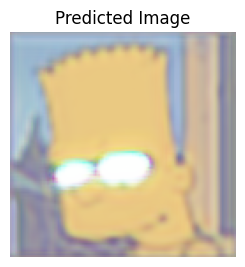

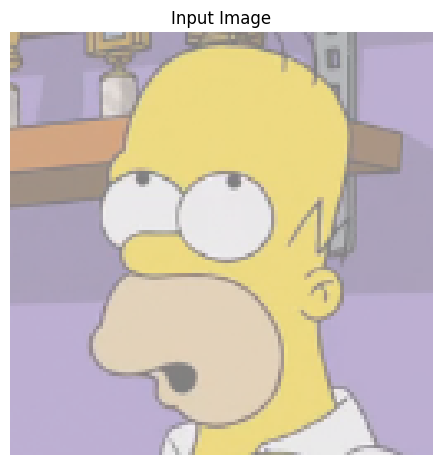

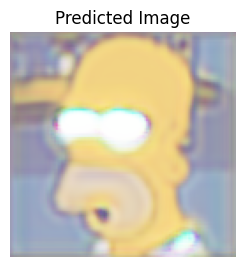

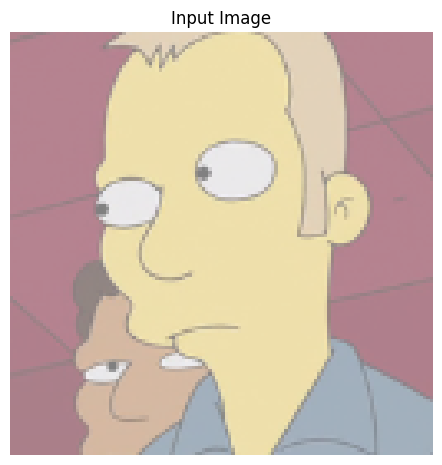

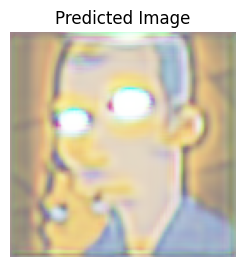

In [ ]:
#Human -> Simpson
for i in range(5):
  generate_images(generator_AtoB, np.expand_dims(dataA[i], axis=0))

#Simpson -> Human
for i in range(5):
  generate_images(generator_AtoB, np.expand_dims(dataB[i], axis=0))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embeddings = self.add_weight(shape=(embedding_dim, num_embeddings),
                                          initializer='uniform',
                                          trainable=True)

    def call(self, inputs):
        flat_inputs = tf.reshape(inputs, [-1, self.embedding_dim])
        distances = tf.reduce_sum(flat_inputs**2, axis=1, keepdims=True) + \
                    tf.reduce_sum(self.embeddings**2, axis=0) - \
                    2 * tf.matmul(flat_inputs, self.embeddings)
        encoding_indices = tf.argmax(-distances, axis=1)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, tf.shape(inputs))
        return quantized

def build_vqvae(image_shape, num_embeddings, embedding_dim):
    encoder_inputs = layers.Input(shape=image_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2D(embedding_dim, (1, 1), padding='same')(x)
    encoder_outputs = x

    quantizer = VectorQuantizer(num_embeddings, embedding_dim)
    quantized = quantizer(encoder_outputs)

    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(quantized)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2D(image_shape[-1], (3, 3), padding='same')(x)

    vqvae = Model(encoder_inputs, decoder_outputs, name='vqvae')
    return vqvae

image_shape = (128, 128, 3)
num_embeddings = 512
embedding_dim = 64

vqvae = build_vqvae(image_shape, num_embeddings, embedding_dim)
vqvae.compile(optimizer='adam', loss='mse')

# Entraînement du VQ-VAE
vqvae.fit(dataA, dataA, epochs=50, batch_size=32)
vqvae.fit(dataB, dataB, epochs=50, batch_size=32)

# Génération d'images
def generate_vqvae_images(model, test_input):
    prediction = model.predict(test_input)
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

sample_human = dataA[0:1]
sample_simpson = dataB[0:1]

generate_vqvae_images(vqvae, sample_human)
generate_vqvae_images(vqvae, sample_simpson)

Epoch 1/50


30/30 [==============================] - 2s 41ms/step - loss: 0.1490
Epoch 2/50
30/30 [==============================] - 1s 39ms/step - loss: 0.0441
Epoch 3/50
30/30 [==============================] - 1s 41ms/step - loss: 0.0352
Epoch 4/50
30/30 [==============================] - 1s 40ms/step - loss: 0.0383
Epoch 5/50
30/30 [==============================] - 1s 42ms/step - loss: 0.0407
Epoch 6/50
30/30 [==============================] - 1s 39ms/step - loss: 0.0417
Epoch 7/50
30/30 [==============================] - 1s 38ms/step - loss: 0.0419
Epoch 8/50
30/30 [==============================] - 1s 38ms/step - loss: 0.0416
Epoch 9/50
30/30 [==============================] - 1s 38ms/step - loss: 0.0419
Epoch 10/50
30/30 [==============================] - 1s 38ms/step - loss: 0.0414
Epoch 11/50
30/30 [==============================] - 1s 38ms/step - loss: 0.0412
Epoch 12/50
30/30 [==============================] - 1s 38ms/step - loss: 0.0412
Epoch 13/50
30/30 [=============================

In [ ]:
#Human -> Simpson
for i in range(5):
  generate_vqvae_images(vqvae, np.expand_dims(dataA[i], axis=0))

#Simpson -> Human
for i in range(5):
  generate_vqvae_images(vqvae, np.expand_dims(dataB[i], axis=0))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

# Define the forward diffusion process
def forward_diffusion_process(x0, t, noise):
    t = tf.cast(t, tf.int32)
    beta_t = tf.gather(beta, t)
    return tf.sqrt(1 - beta_t) * x0 + tf.sqrt(beta_t) * noise

# Define the reverse diffusion model
def define_diffusion_model(image_shape):
    init = RandomNormal(stddev=0.02)
    input_image = tf.keras.Input(shape=image_shape)
    x = layers.Conv2D(64, (7, 7), padding='same', kernel_initializer=init)(input_image)
    x = layers.Activation('relu')(x)

    c1 = layers.Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=init)(x)
    c1 = layers.Activation('relu')(c1)

    c2 = layers.Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=init)(c1)
    c2 = layers.Activation('relu')(c2)

    c3 = layers.Conv2D(512, (3, 3), strides=2, padding='same', kernel_initializer=init)(c2)
    c3 = layers.Activation('relu')(c3)

    u1 = layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same', kernel_initializer=init)(c3)
    u1 = layers.Activation('relu')(u1)

    u2 = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=init)(u1)
    u2 = layers.Activation('relu')(u2)

    u3 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=init)(u2)
    u3 = layers.Activation('relu')(u3)

    output_image = layers.Conv2D(3, (7, 7), activation='tanh', padding='same', kernel_initializer=init)(u3)

    model = tf.keras.Model(input_image, output_image)
    return model

# Hyperparameters
T = 1000  # Total number of diffusion steps
beta = np.linspace(0.0001, 0.02, T).astype(np.float32)  # Linear schedule for beta

# Define the diffusion model
image_shape = (128, 128, 3)
diffusion_model = define_diffusion_model(image_shape)
diffusion_optimizer = Adam(2e-4, beta_1=0.5)

# Loss function
def diffusion_loss(real_image, noise):
    predicted_noise = diffusion_model(real_image)
    return tf.reduce_mean(tf.keras.losses.mean_squared_error(noise, predicted_noise))

# Training step
@tf.function
def train_diffusion_step(real_image, t):
    with tf.GradientTape() as tape:
        noise = tf.random.normal(shape=tf.shape(real_image))
        noisy_image = forward_diffusion_process(real_image, t, noise)
        loss = diffusion_loss(noisy_image, noise)

    gradients = tape.gradient(loss, diffusion_model.trainable_variables)
    diffusion_optimizer.apply_gradients(zip(gradients, diffusion_model.trainable_variables))
    return loss

# Training the diffusion model
epochs = 50
for epoch in range(epochs):
    for i in range(len(dataA)):
        t = np.random.randint(0, T)
        real_image = np.expand_dims(dataA[i], axis=0).astype(np.float32)
        loss = train_diffusion_step(real_image, t)
        print(f"Epoch {epoch+1}, Step {i+1}, Loss: {loss.numpy()}")

# Generate images using the diffusion model
def generate_diffusion_images(model, sample_human, sample_simpson):
    generated_human = model(np.expand_dims(sample_human, axis=0))
    generated_simpson = model(np.expand_dims(sample_simpson, axis=0))

    display_list = [sample_human, generated_human[0], sample_simpson, generated_simpson[0]]
    title = ['Input Human Image', 'Generated Simpson Image', 'Input Simpson Image', 'Generated Human Image']

    plt.figure(figsize=(12, 12))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

sample_human = dataA[0].astype(np.float32)
sample_simpson = dataB[0].astype(np.float32)

generate_diffusion_images(diffusion_model, sample_human, sample_simpson)

ValueError: in user code:

    File "<ipython-input-48-60bb4758395c>", line 52, in train_diffusion_step  *
        loss = diffusion_loss(noisy_image, noise, t)
    File "<ipython-input-48-60bb4758395c>", line 44, in diffusion_loss  *
        return tf.reduce_mean(tf.keras.losses.mean_squared_error(noise, predicted_noise))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 1706, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 32 and 128 for '{{node SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model_31/conv2d_411/Tanh, random_normal)' with input shapes: [1,32,32,3], [1,128,128,3].
